## Создание простейшей сиамской нейросети

две совпадающие модели, выделяющие признаки, на выходе функция энергии рассчитывает различия между объектами

In [107]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.ImageOps
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils
from PIL import Image
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import random

from src.train import fit

## Пример на MNIST 

### Загрузка и нормализация

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

In [3]:
mnist.data.shape

(70000, 784)

In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [5]:
X /= 255.0

In [6]:
X.min(), X.max()

(0.0, 1.0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [8]:
assert (X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [9]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Отображение

In [10]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

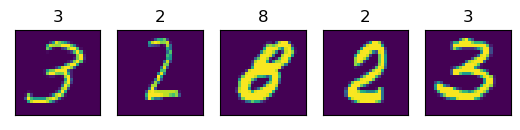

In [11]:
plot_example(X_train, y_train)

## Создание модели

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
mnist_dim = X.shape[1]  # object pixels count
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))  # classes count

In [14]:
X.shape

(70000, 784)

In [15]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

In [16]:
class MnistClassifier(nn.Module):
    def __init__(
        self,
        input_dim=mnist_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        dropout=0.5
    ) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, **kwargs):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=-1)
        return x

In [17]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    MnistClassifier,
    max_epochs=20,
    lr=0.05,
    device=device
)

In [18]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0942       0.8664        0.5168  1.2867
      2        0.5418       0.8928        0.3857  0.9715
      3        0.4456       0.9067        0.3366  0.8534
      4        0.3957       0.9151        0.3021  0.7501
      5        0.3683       0.9203        0.2779  0.7236
      6        0.3434       0.9256        0.2597  0.8256
      7        0.3233       0.9304        0.2429  0.8209
      8        0.3067       0.9326        0.2307  0.7560
      9        0.2950       0.9364        0.2203  0.7516
     10        0.2822       0.9379        0.2115  0.6621
     11        0.2745       0.9405        0.2025  0.7543
     12        0.2612       0.9438        0.1955  0.6910
     13        0.2545       0.9443        0.1904  0.7356
     14        0.2486       0.9456        0.1845  0.7373
     15        0.2438       0.9485        0.1776  0.7927
     16        0.2359       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MnistClassifier(
    (fc1): Linear(in_features=784, out_features=98, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=98, out_features=10, bias=True)
  ),
)

In [19]:
y_pred = net.predict(X_test)

In [20]:
accuracy_score(y_test, y_pred)

0.9530285714285714

In [21]:
error_mask = y_pred != y_test

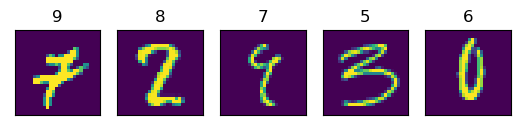

In [22]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [23]:
len(y_test[error_mask])

822

### Сверточная сеть

In [24]:
X_CNN = X.reshape(-1, 1, 28, 28)

In [25]:
X_CNN.shape

(70000, 1, 28, 28)

In [26]:
X_CNN_train, X_CNN_test, y_train, y_test = train_test_split(
    X_CNN, y, test_size=0.25, random_state=42)

In [27]:
X_CNN_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [28]:
class MnistClassifierConvolutional(nn.Module):
    def __init__(self, dropout=0.5) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        return x

In [29]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    MnistClassifierConvolutional,
    max_epochs=10,
    lr=1e-3,
    optimizer=torch.optim.Adam,
    device=device
)

In [30]:
cnn.fit(X_CNN_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.5166       0.9668        0.1063  12.2538
      2        0.1687       0.9766        0.0763  11.5571
      3        0.1304       0.9808        0.0624  11.5794


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MnistClassifierConvolutional(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=1600, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=10, bias=True)
    (fc1_drop): Dropout(p=0.5, inplace=False)
  ),
)

In [31]:
y_pred_cnn = cnn.predict(X_CNN_test)

In [32]:
accuracy_score(y_test, y_pred_cnn)

0.9811428571428571

In [33]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7068126520681265

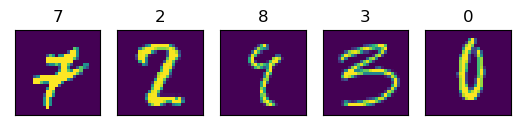

In [34]:
plot_example(X_CNN_test[error_mask], y_pred_cnn[error_mask])

In [35]:
error_mask_cnn = y_pred_cnn != y_test

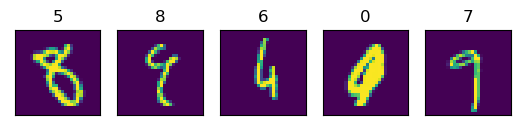

In [36]:
plot_example(X_CNN_test[error_mask_cnn], y_pred_cnn[error_mask_cnn])

In [37]:
len(y_test[error_mask_cnn])

330

### Сиамская сеть

In [51]:
X_CNN = X.reshape(-1, 1, 28, 28)

In [52]:
X_CNN_train, X_CNN_test, y_train, y_test = train_test_split(
    X_CNN, y, test_size=0.25, random_state=42)

In [53]:
X_CNN_train.shape, y_train.shape, X_CNN_test.shape, y_test.shape

((52500, 1, 28, 28), (52500,), (17500, 1, 28, 28), (17500,))

In [92]:
class ConvBlock(nn.Module):
    """Блок свертки с батч-нормализацией и активацией relu"""

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3
    ) -> None:
        super().__init__()
        self.seq = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=in_channels,
             out_channels=out_channels, kernel_size=kernel_size)),
            ('bn1', nn.BatchNorm2d(num_features=out_channels)),
            ('relu1', nn.ReLU())
        ]))

    def forward(self, x):
        return self.seq(x)


class InnerCNN(nn.Module):
    """Сверточная сеть, используемая внутри сиамской сети"""

    def __init__(self) -> None:
        super().__init__()
        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.pool1 = nn.AvgPool2d(kernel_size=2),
        self.fc1 = nn.Linear(in_features=2 * 2 * 256, out_features=64)
        # self.relu1 = nn.ReLU()

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.pool1(x)
        x = x.view(-1, 2 * 2 * 256)
        x = self.fc1(x)
        # x = self.relu1(x)

# class MnistClassifierSiamese(nn.Module):

In [93]:
model = InnerCNN()
model

InnerCNN(
  (conv_block1): ConvBlock(
    (seq): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
    )
  )
  (conv_block2): ConvBlock(
    (seq): Sequential(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
    )
  )
  (conv_block3): ConvBlock(
    (seq): Sequential(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
    )
  )
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
)

In [89]:
siamese_model = NeuralNetClassifier(
    InnerCNN,
    max_epochs=10,
    lr=1e-3,
    optimizer=torch.optim.Adam,
    device=device
)

In [91]:
siamese_model.fit(X_CNN_train, y_train)

TypeError: 'tuple' object is not callable

## Пример с AT&T - faces dataset

In [95]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [96]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        # We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                # Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                # Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [104]:
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

In [105]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100, 100)),
                                     transforms.ToTensor()
                                     ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

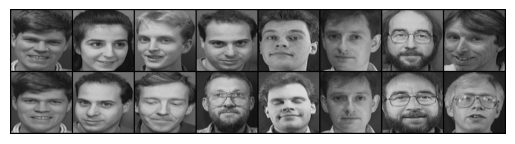

[0. 1. 1. 1. 0. 0. 0. 1.]


In [110]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=2,
                            batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [112]:
# create the Siamese Neural Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )
        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [111]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidian distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(
            output1, output2, keepdim=True)

        loss_contrastive = torch.mean(
            (1-label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [118]:
# Load the training dataset
train_dataloader = DataLoader(
    siamese_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=8
)

In [119]:
len(train_dataloader)

47

In [121]:
net = SiameseNetwork()
lr = 5e-4
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr)

In [123]:
counter = []
loss_history = []
iteration_number = 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        # Send the images and labels to CUDA
        # img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        # Zero the gradients
        optimizer.zero_grad()
        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)
        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)
        # Calculate the backpropagation
        loss_contrastive.backward()
        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0:
            print(
                f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

Epoch number 0
 Current loss 2.4983935356140137

Epoch number 0
 Current loss 0.7219963073730469

Epoch number 0
 Current loss 0.4624488949775696

Epoch number 0
 Current loss 1.026406168937683

Epoch number 0
 Current loss 0.5134813785552979

Epoch number 1
 Current loss 0.43307554721832275

Epoch number 1
 Current loss 0.8111211657524109

Epoch number 1
 Current loss 0.13999716937541962

Epoch number 1
 Current loss 0.8284702897071838

Epoch number 1
 Current loss 1.3508639335632324

Epoch number 2
 Current loss 0.43176600337028503

Epoch number 2
 Current loss 0.5741543769836426

Epoch number 2
 Current loss 0.6125789284706116

Epoch number 2
 Current loss 0.9396703243255615

Epoch number 2
 Current loss 0.24429669976234436

Epoch number 3
 Current loss 0.5506707429885864

Epoch number 3
 Current loss 0.9814140200614929

Epoch number 3
 Current loss 0.000486060424009338

Epoch number 3
 Current loss 0.5837849974632263

Epoch number 3
 Current loss 0.5453959703445435

Epoch number 4


KeyboardInterrupt: 

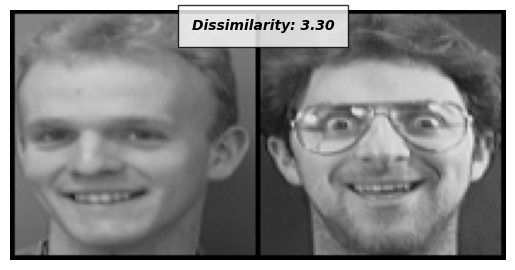

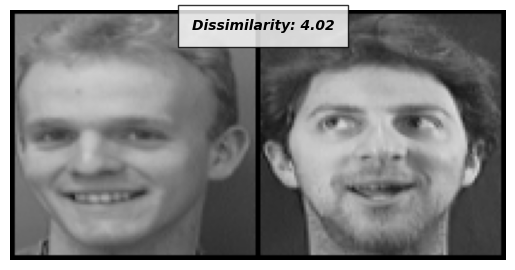

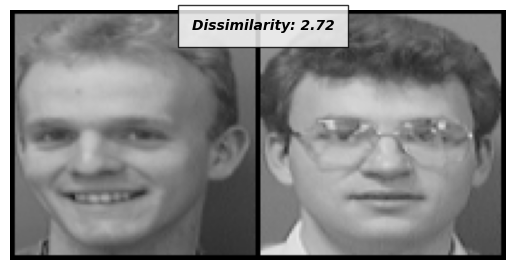

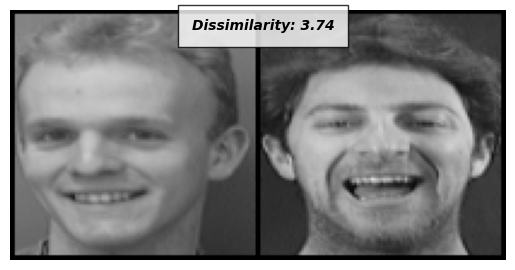

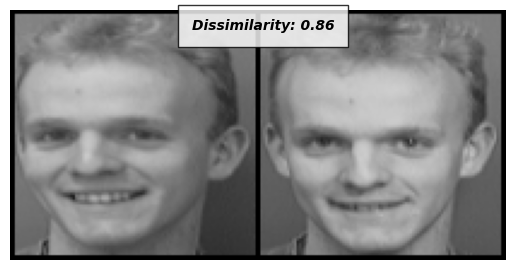

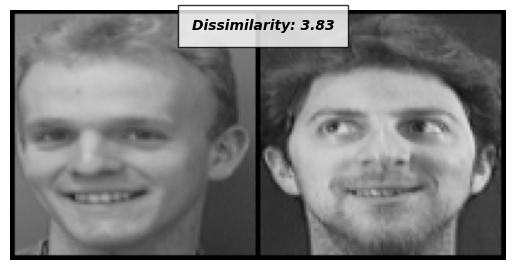

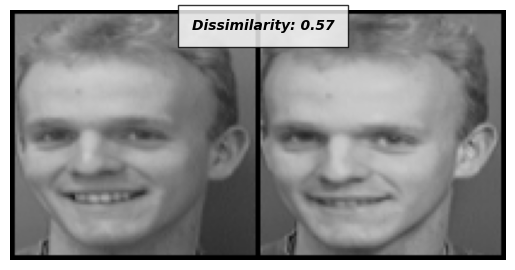

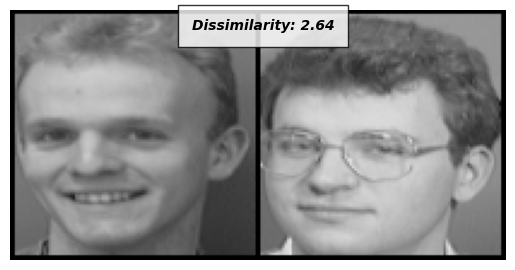

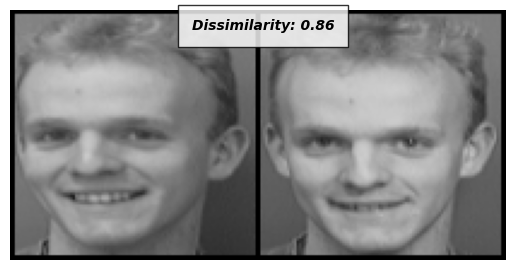

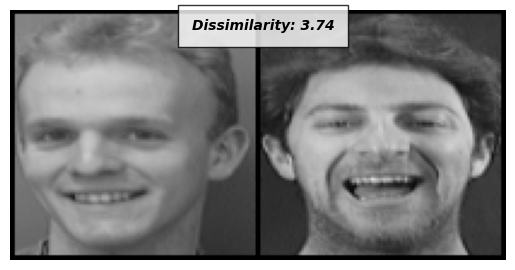

In [124]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(
    siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),
           f'Dissimilarity: {euclidean_distance.item():.2f}')